## Train

* model : swin 224 or swin 384
* Sturges' rule : bins 14 -> 44

### Import

In [1]:
import sys
import timm
from timm import create_model
from fastai.vision.all import *
import gc
import glob
import torch

In [2]:
set_seed(999, reproducible=True)
Image_size = 224
epoch = 5
Model_name = "swin_large_patch4_window7_224"
dataset_path = Path('./')
dataset_path.ls()
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scale = StandardScaler()
train_df = pd.read_csv(dataset_path/'train.csv')

train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

meta =True
# if meta:
#     def size_and_shape(row):
#         img = Image.open(row['path'])
#         return pd.Series([img.size[0], img.size[1], img.size[1]/img.size[0], img.size[0]/img.size[1], os.path.getsize(row['path'])])

#     scale = MinMaxScaler()

#     train_df[['width', 'height', 'hw_ratio', 'wh_ratio', 'size']] = pd.DataFrame(scale.fit_transform(train_df.apply(size_and_shape, axis=1).values))

In [4]:
train_df

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,train/7b77e1a6d93667b575d57db83facd860.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,1,1,1,0,0,0,0,0,0,0,0,26,train/d9a59cf5f9b386ca222cdc348335c143.jpg
9908,0,1,1,1,0,0,0,0,0,0,0,0,65,train/c3ae20e7de8c74a62a37166bb57f4e2e.jpg
9909,0,1,1,0,0,0,0,0,1,1,0,0,38,train/d9ea120ce5d5213ba2dc31b23de439e6.jpg
9910,0,1,1,1,0,0,0,0,0,0,0,0,44,train/9714de78407cc26d1ecbdcae534e1cee.jpg


In [5]:
seed=999#42
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [6]:
BATCH_SIZE = 32
torch.cuda.set_device(0)

In [7]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score
0,0,0,1,1,0,0,0,0,0,0,0,1,50,train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg,0.50
1,0,1,1,1,0,1,0,1,0,0,1,0,25,train/25e3bf4267c2dc3f579b779418221bb7.jpg,0.25
2,0,0,1,1,0,1,0,0,0,0,0,0,27,train/6548166fb3fda22b67881176397f0223.jpg,0.27
3,0,1,1,1,0,0,0,0,1,1,0,0,19,train/472c40116e1833555715e4774445ae5b.jpg,0.19
4,0,1,1,1,0,0,0,1,0,0,0,0,27,train/7b77e1a6d93667b575d57db83facd860.jpg,0.27


## Data loading

In [8]:
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
num_bins 

44

In [9]:
# num_bins = int(np.floor(1+(np.log2(len(train_df)))))
# num_bins

In [10]:
# num_bins = int(np.ceil(2*((len(train_df))**(1./3))))

# num_bins 

Sturges rule에 따라 전체 데이터셋의 길이를 나눠서 Pawpularity에 따라 bins 순으로 나눠준다.

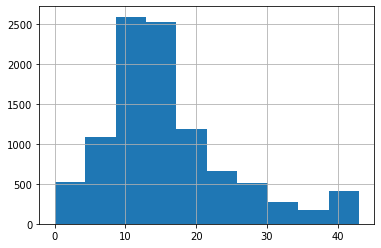

In [11]:
train_df['bins'] = pd.cut(train_df['norm_score'],bins=num_bins,labels=False)
train_df['bins'].hist();

<AxesSubplot:>

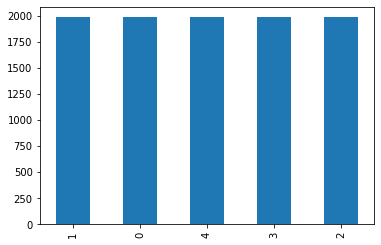

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold #bins의 밸런스를 고려하여 10폴드를 구성

train_df['fold'] = -1

N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state = 123, shuffle=True)

for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index,-1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()


In [13]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [14]:
# def get_data(fold):
#     train_df_f = train_df.copy()
#     train_df_f['is_valid'] = (train_df_f['fold']==fold)
    
#     dls = ImageDataLoaders.from_df(train_df_f,
#                                    valid_col = 'is_valid',
#                                    seed = seed,
#                                    fn_col = 'path',
#                                    label_col = 'norm_score',
#                                    y_block = RegressionBlock,
#                                    bs = BATCH_SIZE,
#                                    num_workers = 8,
#                                    item_tfms = Resize(224),
#                                    batch_tfms = setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #Brightness(), Contrast(), Hue(), Saturation()
#     return dls

In [15]:
meta_target = train_df.drop(['norm_score','Pawpularity','path', 'fold', 'bins'],1).keys().tolist()
print("meta len:",len(meta_target))

meta len: 12


In [16]:
meta=True
if meta:
    def get_data(fold):
        train_df_f = train_df.copy()
        
        if fold != -1:
            train_df_f['is_valid'] = (train_df_f['fold'] == fold)
            print("Using kfold: ", fold)
        elif fold == -1:
            train_df_f['is_valid'] = (train_df_f['fold'].values < 10 ) 
            print("Using Whole dataset for LR finder")

        paw_block = DataBlock(blocks = (ImageBlock, RegressionBlock, RegressionBlock) ,  # input/ output
                              get_x = [ColReader('path'), ColReader(meta_target)], 
                              get_y = ColReader('norm_score') , 
                              item_tfms = Resize(224), 
                              batch_tfms = setup_aug_tfms([
                                  Brightness(),
                                  Contrast(),
                                  Hue(),
                                  Saturation()])
                             )

        paw_dls = paw_block.dataloaders(train_df_f, batch_size=BATCH_SIZE, y_block=RegressionBlock, num_workers=8)
        return paw_dls

In [17]:
# #Valid Kfolder size

# the_data = get_data(0)
# assert (len(the_data.train) + len(the_data.valid)) == (len(train_df) // BATCH_SIZE)

In [18]:
# class PetNet(nn.Module):
#     def __init__(self, model_name='swin_large_patch4_window7_224', out_features=1, inp_channels=3,
#                  pretrained=True, num_dense=12):
#         super().__init__()
#         self.model = create_model(model_name, pretrained=True, in_chans=inp_channels)
#         n_features = self.model.head.in_features #swin : 1536
#         self.model.head = nn.Linear(n_features, 128)
#         self.fc = nn.Sequential(
#            nn.Linear(128 + num_dense, 64), #dense feature 적용
#            nn.ReLU(),
#            nn.Linear(64, out_features)
#         )
#         self.dropout = nn.Dropout(0.1)
#         #self.BatchNorm = nn.BatchNorm1d(128 + num_dense)
    
#     def forward(self, image, dense):
#         embeddings = self.model(image)
#         x = self.dropout(embeddings)
#         x = torch.cat([x, dense], dim=1)
#         output = self.fc(x)
#         return output

In [19]:
class PawpularModel(nn.Module):
    def __init__(self, model_name='swin_large_patch4_window7_224', num_classes=[17,1],
                 n_meta_dim=[256, 128], pretrained=True):
        super().__init__()
        out_dim=num_classes[1]
        n_meta_features=num_classes[0]
        self.n_meta_features = n_meta_features
        self.enet = create_model(model_name, pretrained=True, in_chans=3)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        in_ch = self.enet.head.in_features
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                nn.SiLU(),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                nn.SiLU(),
            )
            in_ch += n_meta_dim[1]
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.head = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, image, features):
        x = self.extract(image).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            x_meta = self.meta(features)
            x = torch.cat((x, x_meta), dim=1)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x))
            else:
                out += self.myfc(dropout(x))
        out /= len(self.dropouts)
        return out

In [20]:
# def get_learner(fold_num):
#     data = get_data(fold_num)
    
#     model = create_model(
#        'swin_large_patch4_window7_224', 
#        pretrained=True, 
#        num_classes=data.c,
#        #opt_func = partial(OptimWrapper, opt=torch.optim.AdamW)
#     )
    
#     learn = Learner(data, model, loss_func = BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse)).to_fp16()
    
#     return learn

In [21]:
def get_learner(fold_num):
    data = get_data(fold_num)
    meta=True
    if meta:
        print("data.c:", data.c)
        model = PawpularModel(num_classes=data.c)
    else:    
        model = create_model(Model_name, pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

## Training

Fold 0 results
Using kfold:  0
data.c: [12, 1]


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.659005,0.651661,18.963606,01:38
1,0.649776,0.644658,18.139183,01:38
2,0.642159,0.640809,17.560293,01:38
3,0.636222,0.639886,17.487822,01:38
4,0.632086,0.638663,17.279478,01:37
5,0.624123,0.641335,17.575142,01:38
6,0.617066,0.642578,17.694496,01:38


/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6516612768173218.
Better model found at epoch 1 with valid_loss value: 0.6446576118469238.
Better model found at epoch 2 with valid_loss value: 0.640809178352356.
Better model found at epoch 3 with valid_loss value: 0.639886200428009.
Better model found at epoch 4 with valid_loss value: 0.6386632323265076.
No improvement since epoch 4: early stopping
Fold 1 results
Using kfold:  1
data.c: [12, 1]


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.661967,0.657438,19.337738,01:38
1,0.646203,0.646288,17.933529,01:38
2,0.641011,0.643218,17.541279,01:38
3,0.636088,0.642946,17.486340,01:38
4,0.629593,0.645775,17.788483,01:38
5,0.626204,0.644853,17.693480,01:38


/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6574376225471497.
Better model found at epoch 1 with valid_loss value: 0.646288275718689.
Better model found at epoch 2 with valid_loss value: 0.6432180404663086.
Better model found at epoch 3 with valid_loss value: 0.6429461240768433.
No improvement since epoch 3: early stopping
Fold 2 results
Using kfold:  2
data.c: [12, 1]


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.661608,0.655494,19.614029,01:38
1,0.646581,0.643939,18.225893,01:37
2,0.641793,0.642428,17.983761,01:38
3,0.637579,0.641099,17.841314,01:38
4,0.632319,0.643266,18.091555,01:38
5,0.626135,0.643990,18.129957,01:38


/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.655494213104248.
Better model found at epoch 1 with valid_loss value: 0.6439386606216431.
Better model found at epoch 2 with valid_loss value: 0.6424275040626526.
Better model found at epoch 3 with valid_loss value: 0.6410989761352539.
No improvement since epoch 3: early stopping
Fold 3 results
Using kfold:  3
data.c: [12, 1]


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.658546,0.655376,19.414440,01:38
1,0.645268,0.643378,17.907557,01:37
2,0.643196,0.641026,17.575893,01:38
3,0.636455,0.643755,17.866217,01:38
4,0.628749,0.642215,17.631910,01:38


/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6553756594657898.
Better model found at epoch 1 with valid_loss value: 0.6433784365653992.
Better model found at epoch 2 with valid_loss value: 0.6410261988639832.
No improvement since epoch 2: early stopping
Fold 4 results
Using kfold:  4
data.c: [12, 1]


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.664004,0.657243,19.736471,01:38
1,0.647082,0.643780,18.071802,01:37
2,0.639786,0.639955,17.654972,01:38
3,0.636701,0.638115,17.424519,01:38
4,0.632634,0.640060,17.663685,01:38
5,0.626344,0.640270,17.667719,01:38


/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6572428941726685.
Better model found at epoch 1 with valid_loss value: 0.6437802910804749.
Better model found at epoch 2 with valid_loss value: 0.6399554014205933.
Better model found at epoch 3 with valid_loss value: 0.6381150484085083.
No improvement since epoch 3: early stopping


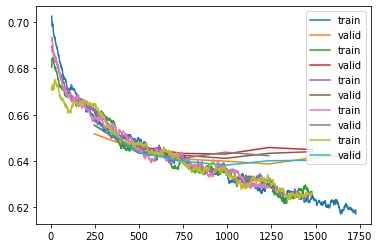

In [22]:
for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i) #dataloader

    learn.fit_one_cycle(10, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

    learn = learn.to_fp32()
    
    #learn.export(f'Add_meta_{model_name}_{i}_fold') #저장
    learn.save(f'Add_meta_seed123_swin_large_patch4_window7_224_{i}_fold') #저장
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [ ]:
np.mean([
    17.493313,
    17.545570,
    17.643105,
    17.901117,
    17.712990,
    17.468822,
    17.253469,
    18.016251,
    17.508446,
    17.900511
    
])

In [ ]:
np.mean([17.792889,
17.830029,
 17.192055,
 17.404383,
 17.644749,
 17.661228,
 17.837669,
 17.284866,
 18.142389,
 17.339655,
])

In [ ]:
np.mean([17.503069,
17.156742,
17.436474,
17.082891,
18.308313,
17.039581,
18.248997,
17.471796,
17.975067,
17.629467,]


)

In [ ]:
import numpy as np

#### seed123

In [ ]:
dataset_path = Path('./clean_dataset/') #27개 중복 이미지 제거
np.mean([18.102615,
17.515541,
17.720085,
17.911230,
17.185228,
17.806900,
17.468006,
17.622896,
17.481623,
17.335798,]


)

#### seed 2999

In [ ]:
np.mean([
17.644304,
17.825743,
17.745024,
17.436764,
17.868528,
17.252687,
17.826439
])

In [ ]:
import numpy as np
np.mean([17.138958,
17.531670,
17.551512,
17.506664,
18.069693,
17.964884,
])

## 실험